## Cunningham and Yuter convective organization test over a 3 hour scene

This notebook tests the Cunningham and Yuter classification over one chosen 3 hour scene.

In [1]:
import pyart
import gzip
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import rcParams
from matplotlib import dates
from scipy import ndimage
import shutil, os
from datetime import timedelta, datetime
import numpy as np
import tempfile
import glob
import re
import time
from copy import deepcopy
from IPython.display import Image, display
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



KeyError: 'PROJ_LIB'

In [ ]:
# Input the range of dates and time wanted for the collection of images
start_year = 2006
start_day = 19
start_month = 1
start_hour = 16
start_minute = 00
start_second = 0

end_year = 2006
end_month = 1
end_day = 19
end_hour = 19
end_minute = 0
end_second = 0

data_path_cpol = '/home/rjackson/data/radar/cpol/'

This looks for all of the available timeperiods in the data_path directory and pulls out
the file names that match the given time periods above.

In [ ]:
# get_radar_times_cpol
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_radar_times_cpol(start_year, start_month, start_day,
                         start_hour, start_minute, end_year,
                         end_month, end_day, end_hour, 
                         end_minute, minute_interval=5):

    from datetime import timedelta, datetime
    start_time = datetime(start_year,
                          start_month,
                          start_day,
                          start_hour,
                          start_minute,
                          )
    end_time = datetime(end_year,
                        end_month,
                        end_day,
                        end_hour,
                        end_minute,
                        )  

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = range(0, no_days)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    

    # Find the list of files for each day
    cur_time = start_time
 
    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path_cpol +
                      'Gunn_pt_' +
                      year_str +
                      month_str +
                      day_str +
                     '*.uf')
    
    
        print('Looking for files with format ' + format_str)
          
        data_list = glob.glob(data_path_cpol +
                             'Gunn_pt_' +
                              year_str +
                              month_str +
                              day_str +
                              '*.uf')
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-26:-12]
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[8:10]
        minute_str = date_str[10:12]
        second_str = date_str[12:14]
        
        
        
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            int(second_str))
        time_list.append(cur_time)
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
    
    
    for times in time_list_sorted: 
        
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
                   
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_radar_from_cpol(time):
    from datetime import timedelta, datetime
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path_cpol +
                     'Gunn_pt_' +
                     year_str +
                     month_str +
                     day_str +
                     hour_str +
                     minute_str +
                     second_str +
                     '_PPI_deal.uf')
    radar = pyart.io.read_uf(file_name_str)
    return radar

In [ ]:
# Plot the radars from given time.

times = get_radar_times_cpol(start_year, start_month, start_day,
                             start_hour, start_minute, end_year,
                             end_month, end_day, end_hour, 
                             end_minute, minute_interval=10)

Test Steiner convective classification on scan

In [ ]:
frame_number = 13
Radar = get_radar_from_cpol(times[frame_number])

print('Calculating texture....')
nyq_Gunn = Radar.instrument_parameters['nyquist_velocity']['data'][0]

data = ndimage.filters.generic_filter(Radar.fields['velocity']['data'],
                                      pyart.util.interval_std, size = (6,6),
                                      extra_arguments = (-nyq_Gunn, nyq_Gunn))
filtered_data = ndimage.filters.median_filter(data, size = (4,4))
texture_field = pyart.config.get_metadata('velocity')
texture_field['data'] = filtered_data

Radar.add_field('velocity_texture', texture_field, replace_existing = True)

In [ ]:
gatefilter_Gunn = pyart.correct.GateFilter(Radar)
gatefilter_Gunn.exclude_above('velocity_texture', 4)

In [ ]:
def grid_radar(radar, grid_shape=(20, 301, 301), xlim=(-150000, 150000),
               ylim=(-150000, 150000), zlim=(1000, 20000), bsp=1.0, 
               min_radius=750, h_factor=4.0, nb=1.5,
               fields=['DT', 'VT'], origin=None):
    bt = time.time()
    radar_list = [radar]
    if origin is None:
        origin = (radar.latitude['data'][0],
                  radar.longitude['data'][0])
    grid = pyart.map.grid_from_radars(
        radar_list, grid_shape=grid_shape,
        grid_limits=(zlim, ylim, xlim),
        grid_origin=origin, fields=fields,
        weighting_function='Cressman',
        gridding_algo='map_gates_to_grid',
        h_factor=h_factor,
        min_radius=min_radius,
        bsp=bsp,
        nb=nb)
    print(time.time() - bt, 'seconds to grid radar')
    return grid

In [ ]:
# Change variable names to DT (reflectivity) and VT (velocity) expected by multidop
# If you needed to dealias or perform other corrections,
# this would be the time to start doing that.
# Both datasets already have aliasing corrections
cp = deepcopy(Radar.fields['corrected_reflectivity']['data'])
texture = Radar.fields['velocity_texture']['data']

# Apply texture filter to CPOL data
cp = np.ma.masked_where(texture > 4, cp)
Radar.add_field_like('corrected_reflectivity', 'reflectivity', cp, replace_existing=True)

grid_cpol = grid_radar(Radar, 
                       origin=(Radar.latitude['data'][0], Radar.longitude['data'][0]),
                       xlim=(-100000, 100000), ylim=(-100000, 100000), 
                       fields=['reflectivity'], min_radius=750.0, bsp=1.0, nb=1.5,
                       h_factor=2.0,
                       zlim=(500, 20000), grid_shape=(40, 121, 121))

Test Steiner classification

In [ ]:
convective = pyart.retrieve.steiner_conv_strat(grid_cpol)
#grid_cpol.add_field('conv_strat', convective)

plt.figure(figsize=(8,14))
plt.subplot(211)
x,y = np.meshgrid(grid_cpol.x['data'], grid_cpol.y['data'])
plt.pcolormesh(x/1e3,y/1e3,convective['data'])
plt.xlabel('Distance from CPOL [km]')
plt.ylabel('Distance from CPOL [km]')

cbar = plt.colorbar(ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['Little precip', 'Stratiform', 'Convection'])
plt.subplot(212)


CPOLGridDisplay = pyart.graph.GridMapDisplay(grid_cpol)
CPOLGridDisplay.plot_grid('reflectivity', 0, vmin=-10, vmax=70,
                          cmap=pyart.graph.cm.NWSRef)

# Calculate parameters needed for classification for whole period

In [94]:
opportunities = len(times)

precip_types = np.ma.zeros((opportunities, len(grid_cpol.x['data']), len(grid_cpol.y['data'])))

i = 0
for t in times:
    Radar = get_radar_from_cpol(t)

    print('Calculating texture....')
    nyq_Gunn = Radar.instrument_parameters['nyquist_velocity']['data'][0]

    data = ndimage.filters.generic_filter(Radar.fields['velocity']['data'],
                                          pyart.util.interval_std, size = (6,6),
                                          extra_arguments = (-nyq_Gunn, nyq_Gunn))
    filtered_data = ndimage.filters.median_filter(data, size = (4,4))
    texture_field = pyart.config.get_metadata('velocity')
    texture_field['data'] = filtered_data

    Radar.add_field('velocity_texture', texture_field, replace_existing = True)
    cp = deepcopy(Radar.fields['corrected_reflectivity']['data'])
    texture = texture_field['data']

    # Apply texture filter to CPOL data
    cp = np.ma.masked_where(texture > 4, cp)
    Radar.add_field_like('corrected_reflectivity', 'reflectivity', cp, replace_existing=True)

    grid_cpol = grid_radar(Radar, 
                           origin=(Radar.latitude['data'][0], Radar.longitude['data'][0]),
                           xlim=(-100000, 100000), ylim=(-100000, 100000), 
                           fields=['reflectivity'], min_radius=750.0, bsp=1.0, nb=1.5,
                           h_factor=2.0,
                           zlim=(500, 20000), grid_shape=(40, 121, 121))
    
    convective = pyart.retrieve.steiner_conv_strat(grid_cpol)
    precip_types[i,:,:] = convective['data']
    i = i + 1    

Calculating texture....
1.3891019821166992 seconds to grid radar
Calculating texture....
1.3231735229492188 seconds to grid radar
Calculating texture....
1.3289496898651123 seconds to grid radar
Calculating texture....
1.3265936374664307 seconds to grid radar
Calculating texture....
1.3272643089294434 seconds to grid radar
Calculating texture....
1.3298726081848145 seconds to grid radar
Calculating texture....
1.3285377025604248 seconds to grid radar
Calculating texture....
1.510981798171997 seconds to grid radar
Calculating texture....
1.3306241035461426 seconds to grid radar
Calculating texture....
1.3385100364685059 seconds to grid radar
Calculating texture....
1.3337976932525635 seconds to grid radar
Calculating texture....
1.3701019287109375 seconds to grid radar
Calculating texture....
1.3334379196166992 seconds to grid radar
Calculating texture....
1.3412275314331055 seconds to grid radar
Calculating texture....
1.3318591117858887 seconds to grid radar
Calculating texture....
1.

Calculate the convective pixels, convective-stratiform intermittency, and the
total number of precipitation opportunities.

In [95]:
total_frequency = np.zeros((len(grid_cpol.x['data']), 
                           len(grid_cpol.y['data'])))
convective_frequency = np.zeros((len(grid_cpol.x['data']), 
                                 len(grid_cpol.y['data'])))
total_changes = np.zeros((len(grid_cpol.x['data']), 
                          len(grid_cpol.y['data'])))
intermittency = np.zeros((len(grid_cpol.x['data']), 
                          len(grid_cpol.y['data'])))
modes = np.zeros((len(grid_cpol.x['data']), 
                  len(grid_cpol.y['data'])))

for j in range(0, len(grid_cpol.x['data'])):
    for k in range(0, len(grid_cpol.y['data'])):
        ptypes = np.squeeze(precip_types[:,j,k])
        total_frequency[j,k] = sum(np.where(ptypes > 0, 1, 0))
        if(total_frequency[j,k] > 0):
            convective_frequency[j,k] = float(sum(np.where(ptypes == 2, 1, 0))) / float(total_frequency[j,k])
        changes = np.zeros(ptypes.shape)
        changes[1:] = np.diff(ptypes)
        changes[ptypes == 0] = 0
        total_changes[j,k] = sum(changes[ptypes > 0])
        intermittency[j,k] = float(total_changes[j,k])/float(opportunities)
        if(convective_frequency[j,k] < 0.33):
            modes[j,k] = 1
        elif(convective_frequency[j,k] > 0.33 and
             convective_frequency[j,k] < 0.66 and
             intermittency[j,j] > 0.33):
            modes[j,k] = 2
        elif(convective_frequency[j,k] > 0.66):
            modes[j,k] = 3
        else:
            modes[j,k] = 4
        
        # Little precipitation periods
        if(float(total_frequency[j,k]/float(opportunities) < 0.3)):
            modes[j,k] = 0

Plot test of metrics.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
113
113.0
0.0
0.0
Stratiform!


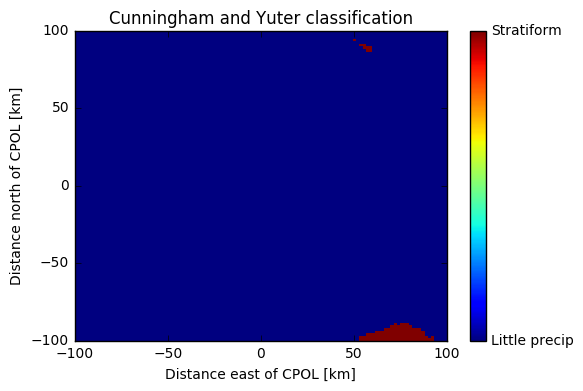

In [96]:
print(ptypes)
plt.figure
plt.pcolormesh(x/1e3,y/1e3,modes)
plt.xlabel('Distance east of CPOL [km]')
plt.ylabel('Distance north of CPOL [km]')
cbar = plt.colorbar(ticks=[0, 1, 2, 3, 4])
cbar.ax.set_yticklabels(['Little precip', 'Stratiform', 'Embedded convection', 'Convection', 'Other'])  
plt.title('Cunningham and Yuter classification')

print(len(np.where(modes > 0)[1]))
total_points = len(np.where(modes > 0)[1])
total_stratiform = len(np.where(modes == 1)[1])
total_embedded = len(np.where(modes == 2)[1])
total_convective = len(np.where(modes == 3)[1])
total_other = len(np.where(modes == 4)[1])

print(float(total_stratiform))
print(float(total_convective))
print(float(total_embedded))

if(float(total_stratiform)/float(total_points) > 0.25):
    print('Stratiform!')
elif(float(total_convective)/float(total_points) > 0.25):
    print('Convective!')
elif(float(total_embedded)/float(total_points) > 0.25):    
    print('Embedded convection!')
else:
    print('Other!')

## Timeseries of Cunningham and Yuter classification for TWP-ICE

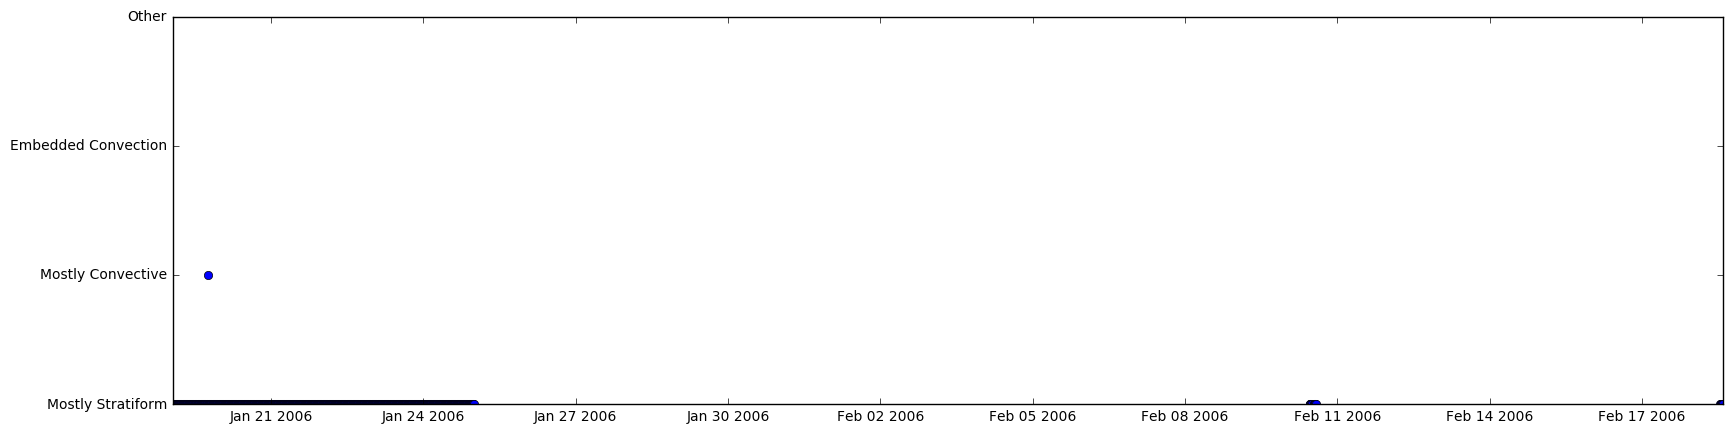

In [3]:
from netCDF4 import Dataset

CY_cdf = Dataset('/home/rjackson/data/CYClassification.cdf', mode='r')

classification = CY_cdf.variables['organization'][:]
year = CY_cdf.variables['year'][:]
month = CY_cdf.variables['month'][:]
day = CY_cdf.variables['day'][:]
hour = CY_cdf.variables['hour'][:]
minute = CY_cdf.variables['minute'][:]

date_array = []
for i in range(0,len(year)):
    dat = datetime(year[i],month[i],day[i],hour[i],minute[i],)
    date_array.append(dat)
CY_cdf.close()

plt.figure(figsize=(20,5))
plt.plot_date(dates.date2num(date_array), classification)
plt.gca().set_yticks([0,1,2,3])
plt.gca().set_yticklabels(['Mostly Stratiform', 'Mostly Convective', 'Embedded Convection', 'Other'])